In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import os

from sklearn.metrics import classification_report
import tensorflow.keras.backend as K
from tensorflow.keras import layers, regularizers

E0000 00:00:1753762006.427847      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


In [27]:
# Config 
INPUT_DIR = Path("/kaggle/working/output_wav2vec_custom_augmented")
OUTPUT_DIR = Path("./out_stFold")
OUTPUT_DIR.mkdir(exist_ok=True)

MAX_SEQ_LEN = 150
EMBEDDING_DIM = 768
LABEL_COLS = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection']
NUM_CLASSES = len(LABEL_COLS)

BATCH_SIZE_PER_REPLICA = 32
EPOCHS = 400
LEARNING_RATE = 1e-4
THRESHOLD = 0.5

TRAIN_DATA_PATH = INPUT_DIR / "train_data.npz"
VAL_DATA_PATH = INPUT_DIR / "val_data.npz"
TEST_DATA_PATH = INPUT_DIR / "test_data.npz"
BEST_MODEL_PATH = OUTPUT_DIR / "run11_regu.keras"

In [3]:
print("--- Initializing TPU Strategy ---")

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu='local')
    # tf.config.experimental_connect_to_cluster(tpu)
    # tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    
    print('TPU successfully initialized. Found TPU: ', tpu.master())
    print("Number of replicas:", strategy.num_replicas_in_sync)

except Exception as e:
    print(f"TPU initialization failed, this is the error: {e}")
    print("Falling back to default strategy (CPU/GPU).")
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA

--- Initializing TPU Strategy ---
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1753762026.294400      10 service.cc:148] XLA service 0x5a8dd61577b0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753762026.294452      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1753762026.294456      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1753762026.294459      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1753762026.294462      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1753762026.294465      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1753762026.294467      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1753762026.294470      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1753762026.294473      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [4]:
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
print(f"Global batch size set to: {BATCH_SIZE}")

Global batch size set to: 256


In [5]:
print("\nLoading all compressed features")

train_data = np.load(TRAIN_DATA_PATH)
val_data = np.load(VAL_DATA_PATH)
test_data = np.load(TEST_DATA_PATH)

# Access the arrays by the keys we used when saving ('x' and 'y')
X_train, y_train = train_data['x'], train_data['y']
X_val, y_val = val_data['x'], val_data['y']
X_test, y_test = test_data['x'], test_data['y']


print("All compressed data loaded successfully.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


Loading all compressed features
All compressed data loaded successfully.
X_train shape: (33945, 150, 768)
y_train shape: (33945, 6)


In [6]:
# Remove the last column ('NoStutter') from the labels
y_train = y_train[:, :-1]
y_val = y_val[:, :-1]
y_test = y_test[:, :-1]

# Filter out samples that now have NO labels
train_indices = np.where(y_train.sum(axis=1) > 0)[0]
val_indices = np.where(y_val.sum(axis=1) > 0)[0]
test_indices = np.where(y_test.sum(axis=1) > 0)[0]

X_train, y_train = X_train[train_indices], y_train[train_indices]
X_val, y_val = X_val[val_indices], y_val[val_indices]
X_test, y_test = X_test[test_indices], y_test[test_indices]

print("Data loaded and modified successfully.")
print(f"New X_train shape: {X_train.shape}")
print(f"New X_test shape: {X_test.shape}")
print(f"New X_val shape: {X_val.shape}")

Data loaded and modified successfully.
New X_train shape: (29783, 150, 768)
New X_test shape: (3906, 150, 768)
New X_val shape: (3676, 150, 768)


In [7]:
print("\n Verifying final training set distribution after augmentation")

final_train_labels_df = pd.DataFrame(y_train, columns=LABEL_COLS)

print("Final distribution of labels in the training set (including augmented samples):")
print(final_train_labels_df.sum().sort_values(ascending=False))


 Verifying final training set distribution after augmentation
Final distribution of labels in the training set (including augmented samples):
Block           10848
Interjection    10824
Prolongation    10800
SoundRep        10576
WordRep         10569
dtype: int64


In [8]:
print("\nBuilding tf.data pipeline")

def prepare_dataset(X, y, shuffle=False, drop_remainder = False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=2048)
    ds = ds.batch(BATCH_SIZE, drop_remainder=drop_remainder)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = prepare_dataset(X_train, y_train, shuffle=True, drop_remainder=True)
val_dataset = prepare_dataset(X_val, y_val, shuffle=False, drop_remainder=True)
test_dataset = prepare_dataset(X_test, y_test, shuffle=False, drop_remainder=True)
print("Datasets created successfully.")


Building tf.data pipeline
Datasets created successfully.


In [ ]:
def create_batch_balanced_bce_loss(num_classes):
    """
    Custom loss function that calculates a class-balanced
    Binary Cross-Entropy loss for each batch.
    """
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())

        # Calculates the number of positive samples for each class in the batch
        class_counts = tf.reduce_sum(y_true, axis=0)
        
        # Calculate inverse frequency weights( Add a small epsilon for numeric stability)
        total_positives = tf.reduce_sum(class_counts)
        weights = total_positives / (class_counts + K.epsilon())

        # Normalization of weights 
        weights = weights / tf.reduce_sum(weights) * num_classes

        # standard bce loss
        bce = K.binary_crossentropy(y_true, y_pred)
        
        # weighted loss
        weighted_bce = bce * weights
        
        # mean loss for the batch
        return K.mean(weighted_bce)

    return loss

In [ ]:
with strategy.scope():
    print("\nBuilding StutterFold Model")

    def conformer_block(x, num_heads=4, ff_dim=128, dropout=0.1):
        # Convolution Module
        x_conv = layers.LayerNormalization()(x)
        x_conv = layers.Conv1D(filters=EMBEDDING_DIM * 2, kernel_size=1, activation="relu")(x_conv)
        x_conv = layers.DepthwiseConv1D(kernel_size=3, padding="same")(x_conv)
        x_conv = layers.BatchNormalization()(x_conv)
        x_conv = layers.Activation("swish")(x_conv)
        x_conv = layers.Conv1D(filters=EMBEDDING_DIM, kernel_size=1, kernel_regularizer=regularizers.l1(5e-5))(x_conv) # L1
        x_conv = layers.Dropout(dropout)(x_conv)
        x = x + x_conv

        # Attention Module
        x_attn = layers.LayerNormalization()(x)
        x_attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=EMBEDDING_DIM // num_heads)(x_attn, x_attn)
        x_attn = layers.Dropout(dropout)(x_attn)
        x = x + x_attn

        # Feed Forward Module
        x_ff = layers.LayerNormalization()(x)
        x_ff = layers.Dense(ff_dim, activation="swish")(x_ff)
        x_ff = layers.Dropout(dropout)(x_ff)
        x_ff = layers.Dense(EMBEDDING_DIM)(x_ff)
        x = x + x_ff

        return x

    def build_stutterfold_model(input_shape, num_classes):
        inputs = layers.Input(shape=input_shape)
        x = inputs

        # Context Refinement using Conformer blocks
        x = conformer_block(x, num_heads=4, ff_dim=1028, dropout=0.4)
        x = conformer_block(x, num_heads=4, ff_dim=1028, dropout=0.4)
        # At this point, x is the enriched feature sequence (Batch, 150, 768)

        # Apply a classifier to every single time step independently
        x = layers.TimeDistributed(
            layers.Dense(num_classes, activation='sigmoid', kernel_regularizer=regularizers.l1(5e-5))    # L1
        )(x)
        # Now, x is the sequence of frame-wise predictions (Batch, 150, 5)
        
        # Pools the frame-wise predictions into a single clip-level prediction
        outputs = layers.GlobalAveragePooling1D()(x)
        # The final output shape is (Batch, 5)
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        
        return model

    model = build_stutterfold_model(input_shape=(MAX_SEQ_LEN, EMBEDDING_DIM), num_classes=NUM_CLASSES)

    optimizer = tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay=1e-4)
    
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc_roc'), tf.keras.metrics.AUC(curve='PR', name='auc_pr')]
    )

model.summary()

print(f"LEARNING RATE: {LEARNING_RATE}")
print(f"BATCH SIZE: {BATCH_SIZE}")


Building StutterFold Model


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 150, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ input_layer_4[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 150, 1536) │  1,181,184 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv1d_10 │ (None, 150, 1536) │      6,144 │ conv1d_20[0][0]   │
│ (DepthwiseConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 1536) │      6,144 │ depthwise_conv1d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 150, 1536) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 150, 768)  │  1,180,416 │ activation_10[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 150, 768)  │          0 │ conv1d_21[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_30 (Add)        │ (None, 150, 768)  │          0 │ input_layer_4[0]… │
│                     │                   │            │ dropout_40[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ add_30[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 150, 768)  │  2,362,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 150, 768)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_31 (Add)        │ (None, 150, 768)  │          0 │ add_30[0][0],     │
│                     │                   │            │ dropout_42[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ add_31[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 150, 1028) │    790,532 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, 150, 1028) │          0 │ dense_24[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 150, 768)  │    790,272 │ dropout_43[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_32 (Add)        │ (None, 150, 768)  │          0 │ add_31[0][0],     │
│                     │                   │            │ dense_25[0][0]  

 Total params: 12,647,181 (48.25 MB)

 Trainable params: 12,641,037 (48.22 MB)

 Non-trainable params: 6,144 (24.00 KB)

LEARNING RATE: 0.0001
BATCH SIZE: 256


In [24]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor='val_auc_roc', mode='max', save_best_only=True, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc_roc', mode='max', patience=10, restore_best_weights=True, verbose=1)


In [29]:
# %%
print("\nStarting Training on TPU")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint, early_stopping]
)


Starting Training on TPU
Epoch 1/400


I0000 00:00:1753769735.917397      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:14150403623006407847
I0000 00:00:1753769738.516817     894 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(1226632305858460105), session_name()
I0000 00:00:1753769782.307090     894 tpu_compile_op_common.cc:245] Compilation of 1226632305858460105 with session name  took 43.790223045s and succeeded
I0000 00:00:1753769782.382747     894 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(1226632305858460105), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_14150403623006407847", property.function_library_fingerprint = 13853090779260213559, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap()

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2973 - auc_pr: 0.5376 - auc_roc: 0.6569 - loss: 3.4501 - precision: 0.5634 - recall: 0.3136

I0000 00:00:1753769812.146340      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:10961132467210822782
I0000 00:00:1753769812.801297     914 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(15203696460035527147), session_name()
I0000 00:00:1753769819.741862     914 tpu_compile_op_common.cc:245] Compilation of 15203696460035527147 with session name  took 6.940484269s and succeeded
I0000 00:00:1753769819.758980     914 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(15203696460035527147), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_10961132467210822782", property.function_library_fingerprint = 12822810226090410318, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap


Epoch 1: val_auc_roc did not improve from 0.73550
116/116 ━━━━━━━━━━━━━━━━━━━━ 108s 349ms/step - accuracy: 0.2976 - auc_pr: 0.5378 - auc_roc: 0.6572 - loss: 3.4481 - precision: 0.5638 - recall: 0.3136 - val_accuracy: 0.2910 - val_auc_pr: 0.5313 - val_auc_roc: 0.6308 - val_loss: 2.8219 - val_precision: 0.5754 - val_recall: 0.2664
Epoch 2/400
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3515 - auc_pr: 0.6177 - auc_roc: 0.7164 - loss: 2.5710 - precision: 0.6582 - recall: 0.3666
Epoch 2: val_auc_roc did not improve from 0.73550
116/116 ━━━━━━━━━━━━━━━━━━━━ 42s 250ms/step - accuracy: 0.3514 - auc_pr: 0.6177 - auc_roc: 0.7165 - loss: 2.5694 - precision: 0.6581 - recall: 0.3667 - val_accuracy: 0.2963 - val_auc_pr: 0.5518 - val_auc_roc: 0.6483 - val_loss: 2.0825 - val_precision: 0.5599 - val_recall: 0.3757
Epoch 3/400
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3635 - auc_pr: 0.6378 - auc_roc: 0.7383 - loss: 1.8765 - precision: 0.6677 - recall: 0.3937
Epoch 3: val_auc_r

BELOW I HAVE TRIED DIFFERENT HYPERPRAMETERS AND CONFIGS FOR THE SAME MODEL AND DATASET.


--- Evaluating Model on the Test Set ---


I0000 00:00:1753710064.274295      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:15137824681334478618
E0000 00:00:1753710064.426246      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/batch_normalization_1/Cast/ReadVariableOp.
I0000 00:00:1753710064.682360     959 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(12178684937981929286), session_name()
I0000 00:00:1753710069.634746     959 tpu_compile_op_common.cc:245] Compilation of 12178684937981929286 with session name  took 4.952310954s and succeeded
I0000 00:00:1753710069.646073     959 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(12178684937981929286), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_15137824681334478618", property.function_library_fingerprint = 9171742768830456824, property.mlir_modu

15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 228ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.64      0.46      0.54      1335
       Block       0.61      0.50      0.55      1982
    SoundRep       0.56      0.45      0.50       886
     WordRep       0.45      0.56      0.50       917
Interjection       0.83      0.71      0.76      1833

   micro avg       0.64      0.55      0.59      6953
   macro avg       0.62      0.53      0.57      6953
weighted avg       0.65      0.55      0.59      6953
 samples avg       0.60      0.57      0.55      6953


--- Generating plots for model training history... ---


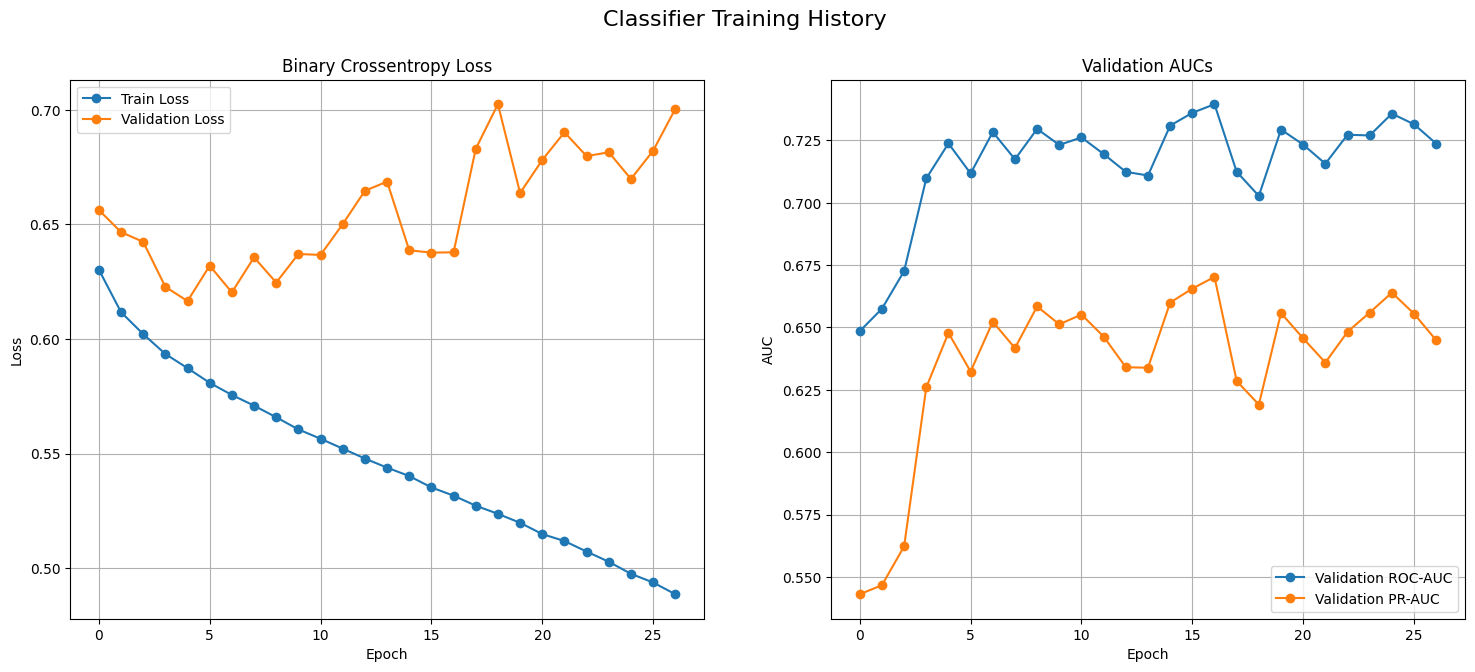

In [ ]:
# lr = 1e-5, dp:0.2
from sklearn.metrics import multilabel_confusion_matrix, precision_recall_curve, average_precision_score
import itertools

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc_roc'], 'o-', label='Validation ROC-AUC')
ax2.plot(history_dict['val_auc_pr'], 'o-', label='Validation PR-AUC')
ax2.set_title('Validation AUCs'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()


--- Evaluating Model on the Test Set ---


I0000 00:00:1753712014.795056      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:1570929014504549669
E0000 00:00:1753712015.033181      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1_1/batch_normalization_2_1/Cast/ReadVariableOp.
I0000 00:00:1753712015.385289     936 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(3793880763008902353), session_name()
I0000 00:00:1753712020.825868     936 tpu_compile_op_common.cc:245] Compilation of 3793880763008902353 with session name  took 5.440519697s and succeeded
I0000 00:00:1753712020.840898     936 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(3793880763008902353), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_1570929014504549669", property.function_library_fingerprint = 17894557765429992693, property.mlir_modu

15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.60      0.54      0.57      1335
       Block       0.59      0.63      0.61      1982
    SoundRep       0.59      0.49      0.54       886
     WordRep       0.49      0.50      0.50       917
Interjection       0.85      0.68      0.75      1833

   micro avg       0.64      0.59      0.61      6953
   macro avg       0.62      0.57      0.59      6953
weighted avg       0.65      0.59      0.61      6953
 samples avg       0.61      0.61      0.57      6953


--- Generating plots for model training history... ---


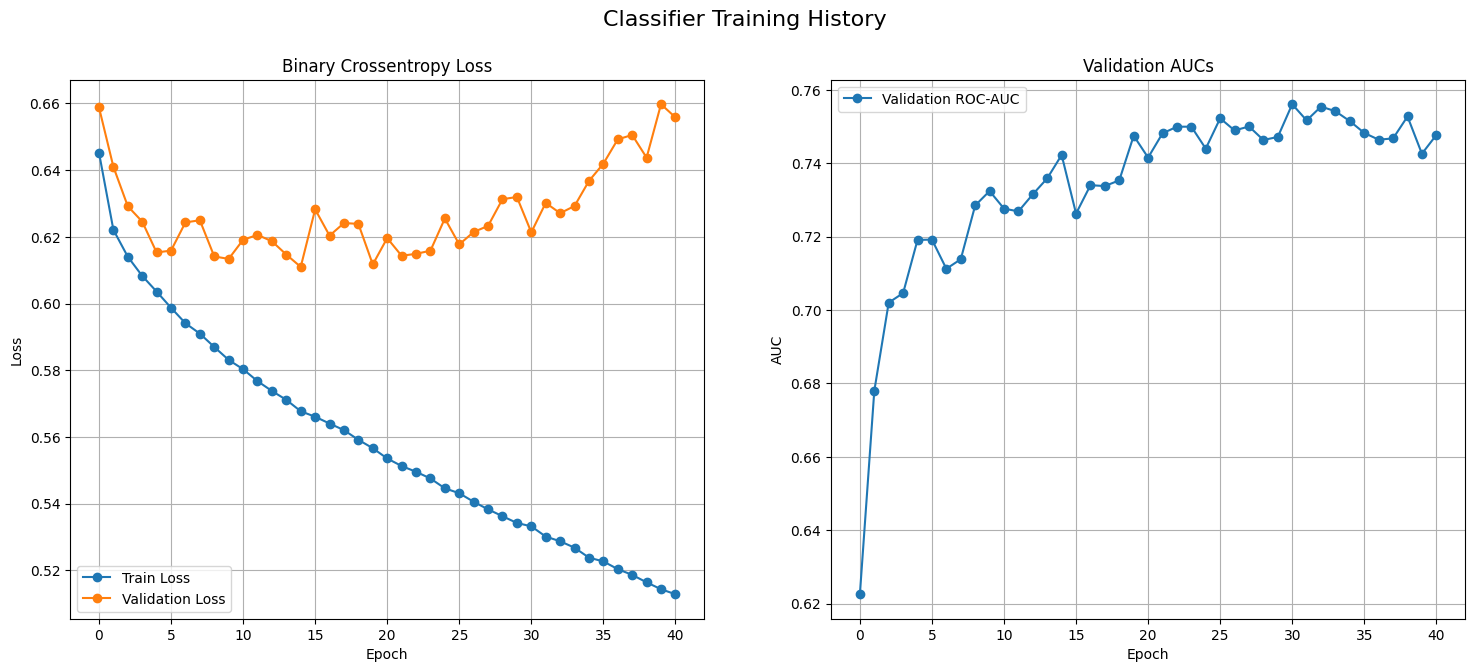

In [ ]:
# lr = 5e-6, dp:0.2



print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc_roc'], 'o-', label='Validation ROC-AUC')
ax2.set_title('Validation AUCs'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()


--- Evaluating Model on the Test Set ---


I0000 00:00:1753716094.519891      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:13860112308638970903
E0000 00:00:1753716094.687941      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_4_1/batch_normalization_7_1/Cast/ReadVariableOp.
I0000 00:00:1753716094.952533     970 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(17318489309628045171), session_name()
I0000 00:00:1753716100.882277     970 tpu_compile_op_common.cc:245] Compilation of 17318489309628045171 with session name  took 5.929680297s and succeeded
I0000 00:00:1753716100.899295     970 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(17318489309628045171), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_13860112308638970903", property.function_library_fingerprint = 2813338738363550229, property.mlir_

15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.60      0.52      0.56      1335
       Block       0.59      0.70      0.64      1982
    SoundRep       0.50      0.62      0.55       886
     WordRep       0.52      0.46      0.49       917
Interjection       0.79      0.77      0.78      1833

   micro avg       0.62      0.64      0.63      6953
   macro avg       0.60      0.61      0.60      6953
weighted avg       0.62      0.64      0.63      6953
 samples avg       0.62      0.66      0.60      6953


--- Generating plots for model training history... ---


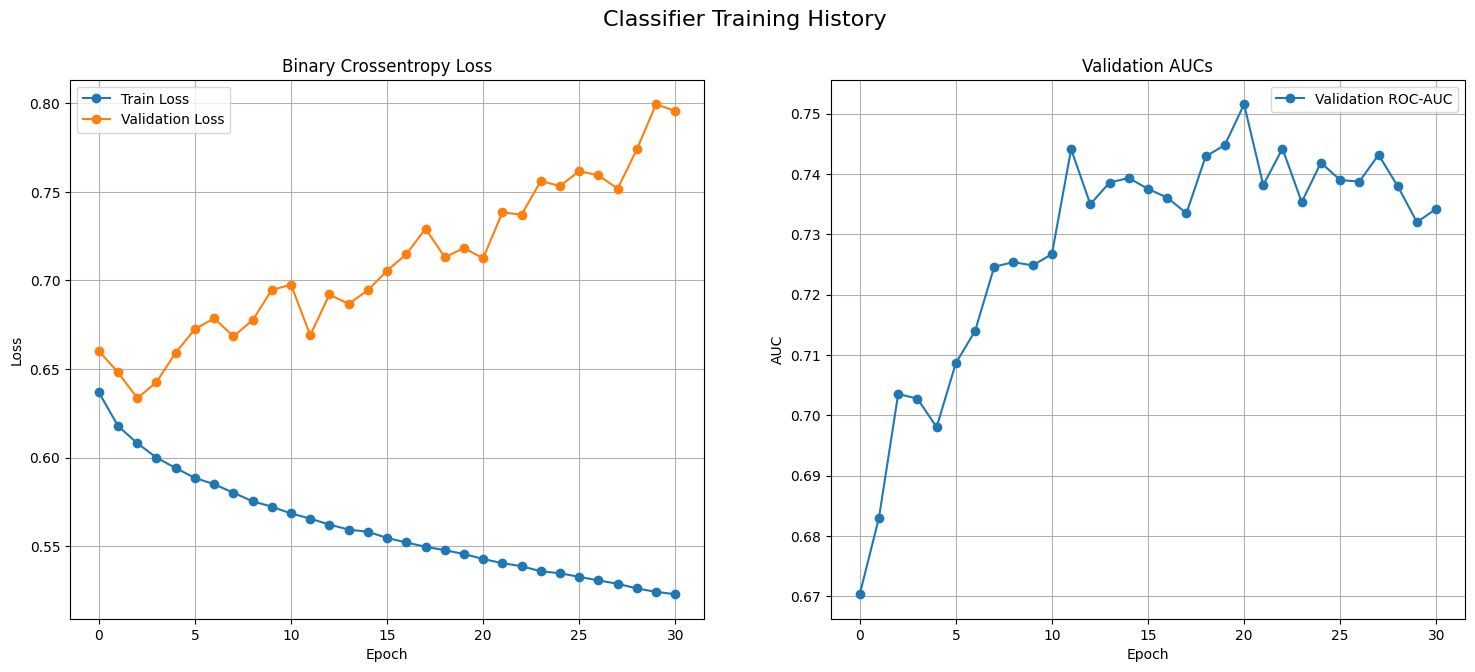

In [ ]:
# AdamW, cnfmr:2, drpt:0.2->0.5, lr = 1e-5

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc_roc'], 'o-', label='Validation ROC-AUC')
ax2.set_title('Validation AUCs'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()


--- Evaluating Model on the Test Set ---


I0000 00:00:1753713845.179571      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:13939341230016073719
E0000 00:00:1753713845.316264      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_2_1/batch_normalization_4_1/Cast/ReadVariableOp.
I0000 00:00:1753713845.523974     919 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(15618928649506042626), session_name()
I0000 00:00:1753713850.921977     919 tpu_compile_op_common.cc:245] Compilation of 15618928649506042626 with session name  took 5.397917984s and succeeded
I0000 00:00:1753713850.934990     919 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(15618928649506042626), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_13939341230016073719", property.function_library_fingerprint = 10827470221299739814, property.mlir

15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 173ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.69      0.40      0.51      1335
       Block       0.62      0.42      0.50      1982
    SoundRep       0.56      0.46      0.51       886
     WordRep       0.47      0.56      0.51       917
Interjection       0.86      0.66      0.75      1833

   micro avg       0.66      0.50      0.57      6953
   macro avg       0.64      0.50      0.56      6953
weighted avg       0.67      0.50      0.57      6953
 samples avg       0.57      0.51      0.50      6953


--- Generating plots for model training history... ---


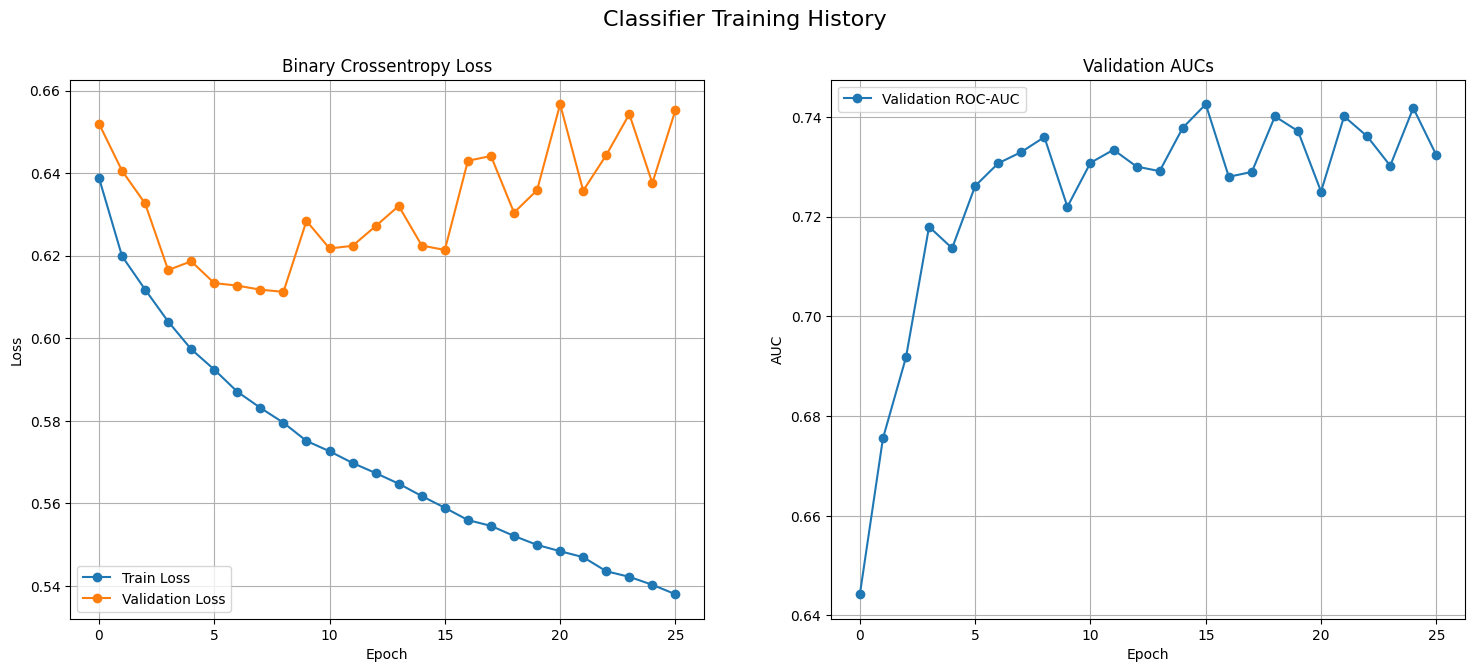

In [ ]:
# simpler model, cnfmr:2->1, drpt:0.2->0.4, lr:1e-5

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc_roc'], 'o-', label='Validation ROC-AUC')
ax2.set_title('Validation AUCs'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()


--- Evaluating Model on the Test Set ---


I0000 00:00:1753718313.990300      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:13591179799942442143
E0000 00:00:1753718314.151663      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_6_1/batch_normalization_11_1/Cast/ReadVariableOp.
I0000 00:00:1753718314.418558     955 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(1893113314499854260), session_name()
I0000 00:00:1753718320.534342     955 tpu_compile_op_common.cc:245] Compilation of 1893113314499854260 with session name  took 6.115716496s and succeeded
I0000 00:00:1753718320.551562     955 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(1893113314499854260), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_13591179799942442143", property.function_library_fingerprint = 13680675602076942809, property.mlir_m

15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 195ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.65      0.49      0.56      1335
       Block       0.59      0.62      0.60      1982
    SoundRep       0.52      0.53      0.53       886
     WordRep       0.40      0.68      0.50       917
Interjection       0.83      0.68      0.75      1833

   micro avg       0.60      0.61      0.60      6953
   macro avg       0.60      0.60      0.59      6953
weighted avg       0.63      0.61      0.61      6953
 samples avg       0.59      0.63      0.57      6953


--- Generating plots for model training history... ---


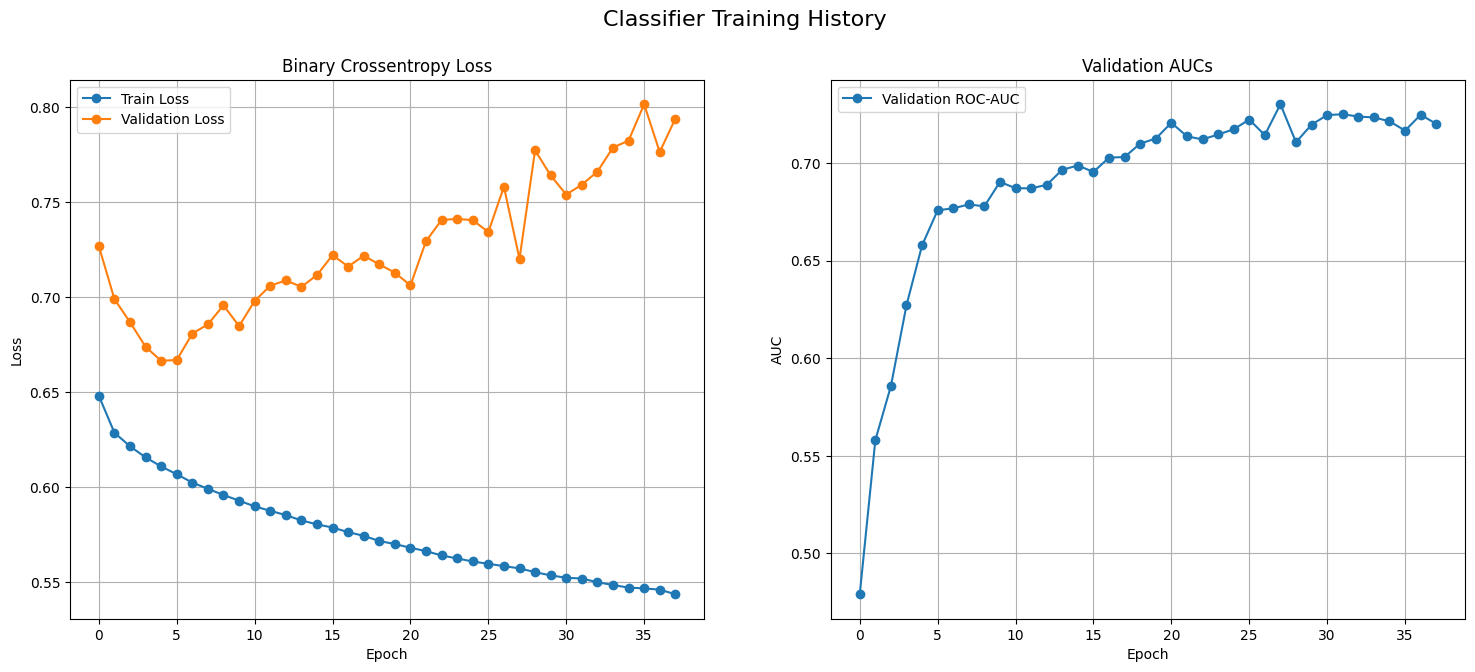

In [ ]:
# AdamW->Adam, cnfmr:2, drpt:0.5, lr=5e-6

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc_roc'], 'o-', label='Validation ROC-AUC')
ax2.set_title('Validation AUCs'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()


--- Evaluating Model on the Test Set ---
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.60      0.54      0.57      1335
       Block       0.60      0.50      0.54      1982
    SoundRep       0.51      0.51      0.51       886
     WordRep       0.42      0.66      0.51       917
Interjection       0.83      0.65      0.73      1833

   micro avg       0.60      0.57      0.58      6953
   macro avg       0.59      0.57      0.57      6953
weighted avg       0.63      0.57      0.59      6953
 samples avg       0.57      0.57      0.53      6953


--- Generating plots for model training history... ---


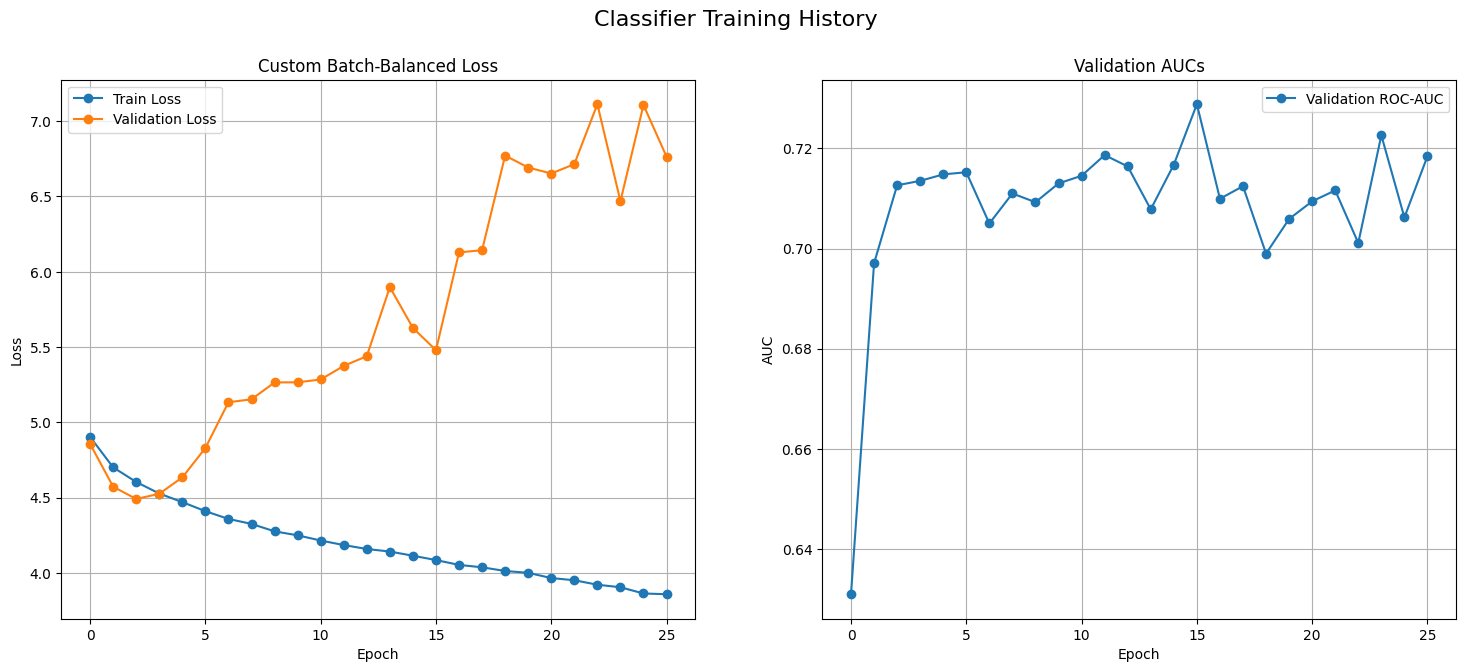

In [ ]:
# AdamW, cnfmr:2, drpt:0.5, lr = 1e-5, CustLoss

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Custom Batch-Balanced Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc_roc'], 'o-', label='Validation ROC-AUC')
ax2.set_title('Validation AUCs'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()


--- Evaluating Model on the Test Set ---


I0000 00:00:1753721859.063763      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:9493295076318357448
E0000 00:00:1753721859.290579      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_9_1/batch_normalization_17_1/Cast/ReadVariableOp.
I0000 00:00:1753721859.624017     967 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(3301994560041665880), session_name()
I0000 00:00:1753721866.294017     967 tpu_compile_op_common.cc:245] Compilation of 3301994560041665880 with session name  took 6.669930918s and succeeded
I0000 00:00:1753721866.307263     967 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(3301994560041665880), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_9493295076318357448", property.function_library_fingerprint = 3732951568623608317, property.mlir_modu

15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 193ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.64      0.46      0.53      1335
       Block       0.61      0.54      0.57      1982
    SoundRep       0.58      0.42      0.49       886
     WordRep       0.39      0.68      0.49       917
Interjection       0.80      0.69      0.74      1833

   micro avg       0.60      0.57      0.58      6953
   macro avg       0.60      0.56      0.57      6953
weighted avg       0.63      0.57      0.59      6953
 samples avg       0.58      0.58      0.54      6953


--- Generating plots for model training history... ---


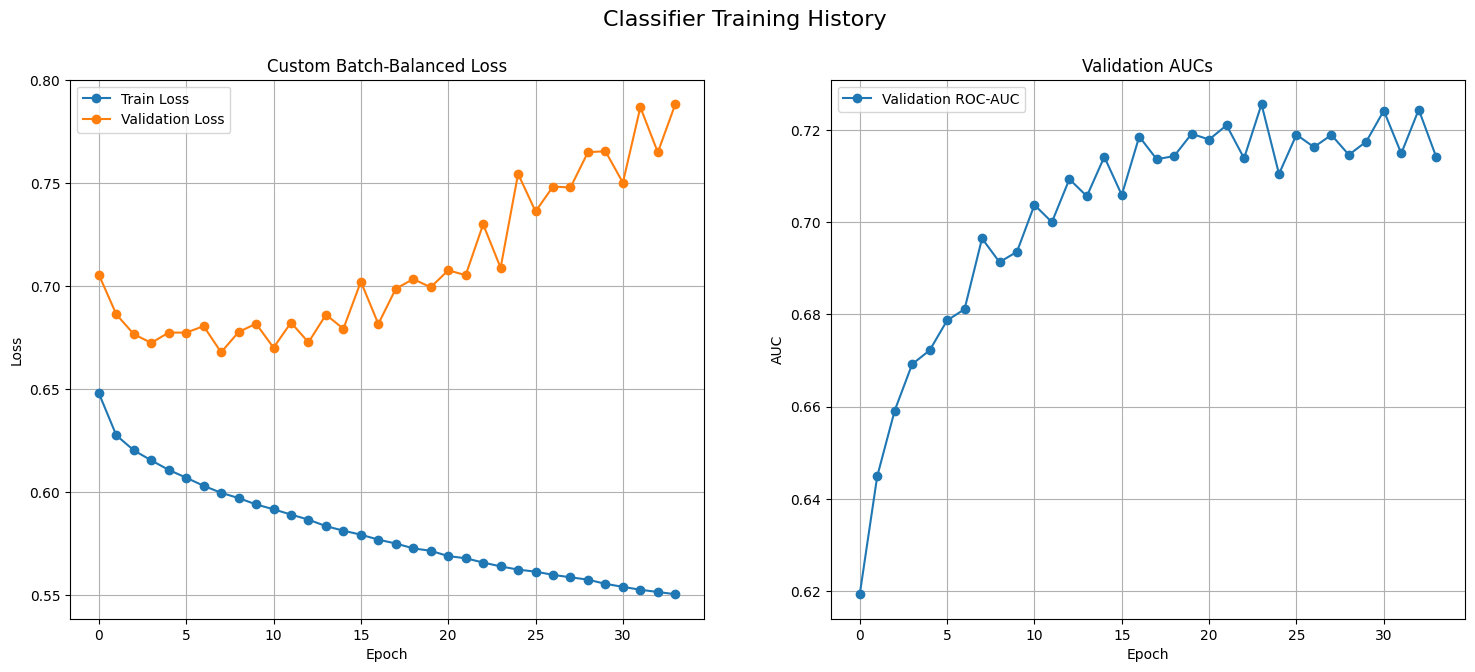

In [ ]:
# AdamW, cnfmr:2, drpt:0.5, lr = 5e-6

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Custom Batch-Balanced Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc_roc'], 'o-', label='Validation ROC-AUC')
ax2.set_title('Validation AUCs'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()


--- Evaluating Model on the Test Set ---


I0000 00:00:1753724342.477098      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:9966505012297561164
E0000 00:00:1753724342.671843      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_10_1/batch_normalization_19_1/Cast/ReadVariableOp.
I0000 00:00:1753724342.966642     955 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(4761158762957763453), session_name()
I0000 00:00:1753724350.014364     955 tpu_compile_op_common.cc:245] Compilation of 4761158762957763453 with session name  took 7.047659245s and succeeded
I0000 00:00:1753724350.030444     955 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(4761158762957763453), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_9966505012297561164", property.function_library_fingerprint = 13317896617464703700, property.mlir_mo

15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 199ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.57      0.62      0.59      1335
       Block       0.57      0.80      0.67      1982
    SoundRep       0.52      0.54      0.53       886
     WordRep       0.50      0.46      0.48       917
Interjection       0.82      0.73      0.77      1833

   micro avg       0.61      0.67      0.64      6953
   macro avg       0.60      0.63      0.61      6953
weighted avg       0.62      0.67      0.64      6953
 samples avg       0.62      0.70      0.62      6953


--- Generating plots for model training history... ---


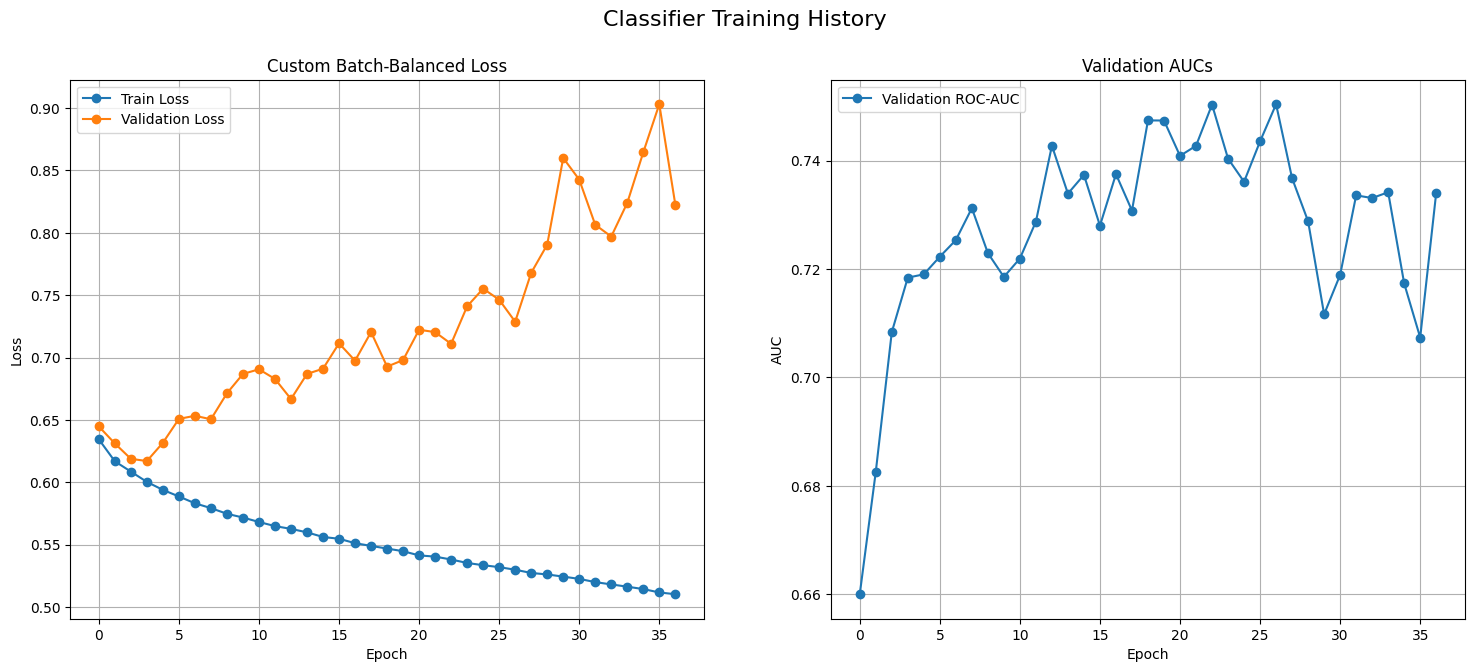

In [ ]:
# AdamW, cnfmr:2, drpt:0.5, lr = 1e-5, copy 

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Custom Batch-Balanced Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc_roc'], 'o-', label='Validation ROC-AUC')
ax2.set_title('Validation AUCs'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()


--- Evaluating Model on the Test Set ---


I0000 00:00:1753727017.735672      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:2783339353370471609
E0000 00:00:1753727017.910101      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_12_1/batch_normalization_25_1/Cast/ReadVariableOp.
I0000 00:00:1753727018.202740     926 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(4946675768536092956), session_name()
I0000 00:00:1753727024.985931     926 tpu_compile_op_common.cc:245] Compilation of 4946675768536092956 with session name  took 6.783038246s and succeeded
I0000 00:00:1753727025.002148     926 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(4946675768536092956), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_2783339353370471609", property.function_library_fingerprint = 6239286664765428485, property.mlir_mod

15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 184ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.57      0.58      0.57      1335
       Block       0.59      0.64      0.61      1982
    SoundRep       0.54      0.52      0.53       886
     WordRep       0.50      0.49      0.50       917
Interjection       0.79      0.77      0.78      1833

   micro avg       0.62      0.63      0.62      6953
   macro avg       0.60      0.60      0.60      6953
weighted avg       0.62      0.63      0.62      6953
 samples avg       0.61      0.65      0.59      6953


--- Generating plots for model training history... ---


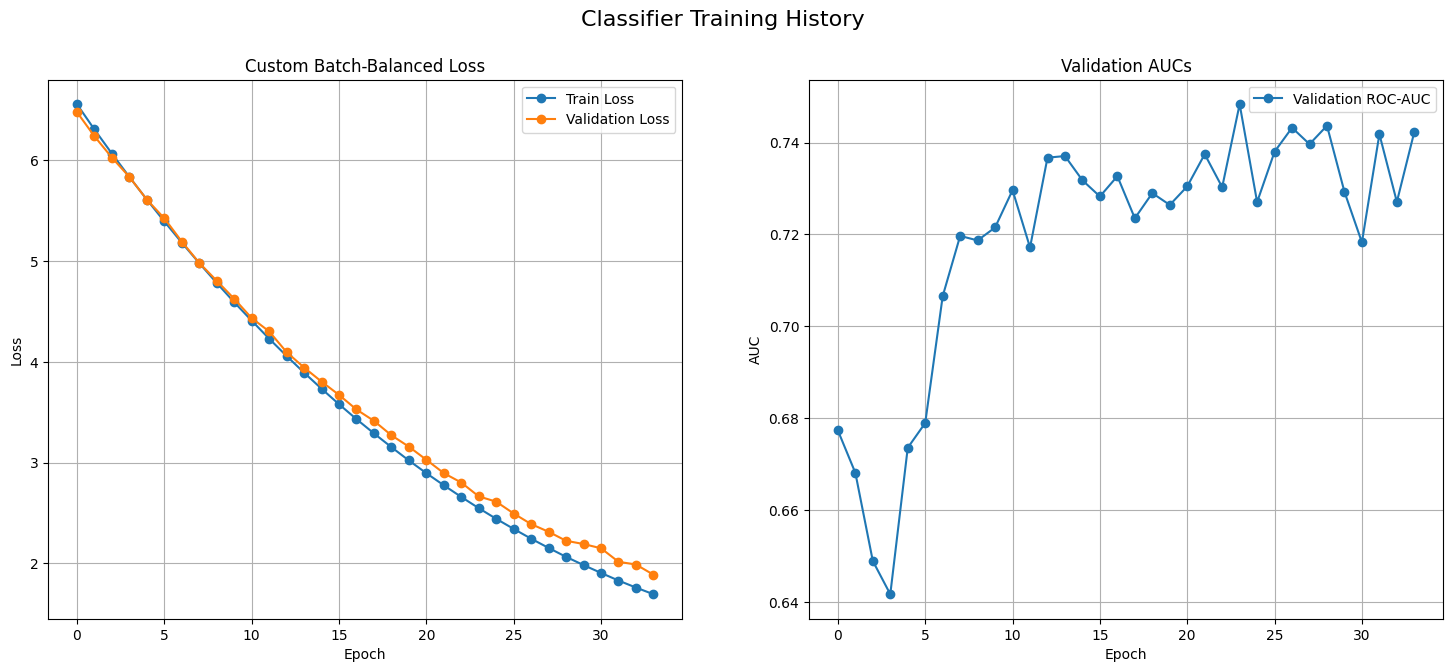

In [ ]:
# AdamW, cnfmr:2, drpt:0.5, lr = 1e-5, l1-regu = 1e-4

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Custom Batch-Balanced Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc_roc'], 'o-', label='Validation ROC-AUC')
ax2.set_title('Validation AUCs'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()


--- Evaluating Model on the Test Set ---


I0000 00:00:1753763823.162632      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:6099943360224238253
E0000 00:00:1753763823.349740      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/batch_normalization_1/Cast/ReadVariableOp.
I0000 00:00:1753763823.635299     926 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(17184991132710328652), session_name()
I0000 00:00:1753763828.683547     926 tpu_compile_op_common.cc:245] Compilation of 17184991132710328652 with session name  took 5.048193019s and succeeded
I0000 00:00:1753763828.697258     926 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(17184991132710328652), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_6099943360224238253", property.function_library_fingerprint = 17299604637374313119, property.mlir_modul

15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 173ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.58      0.56      0.57      1335
       Block       0.56      0.81      0.66      1982
    SoundRep       0.48      0.58      0.53       886
     WordRep       0.52      0.44      0.48       917
Interjection       0.81      0.71      0.76      1833

   micro avg       0.60      0.66      0.63      6953
   macro avg       0.59      0.62      0.60      6953
weighted avg       0.61      0.66      0.63      6953
 samples avg       0.61      0.69      0.61      6953


--- Generating plots for model training history... ---


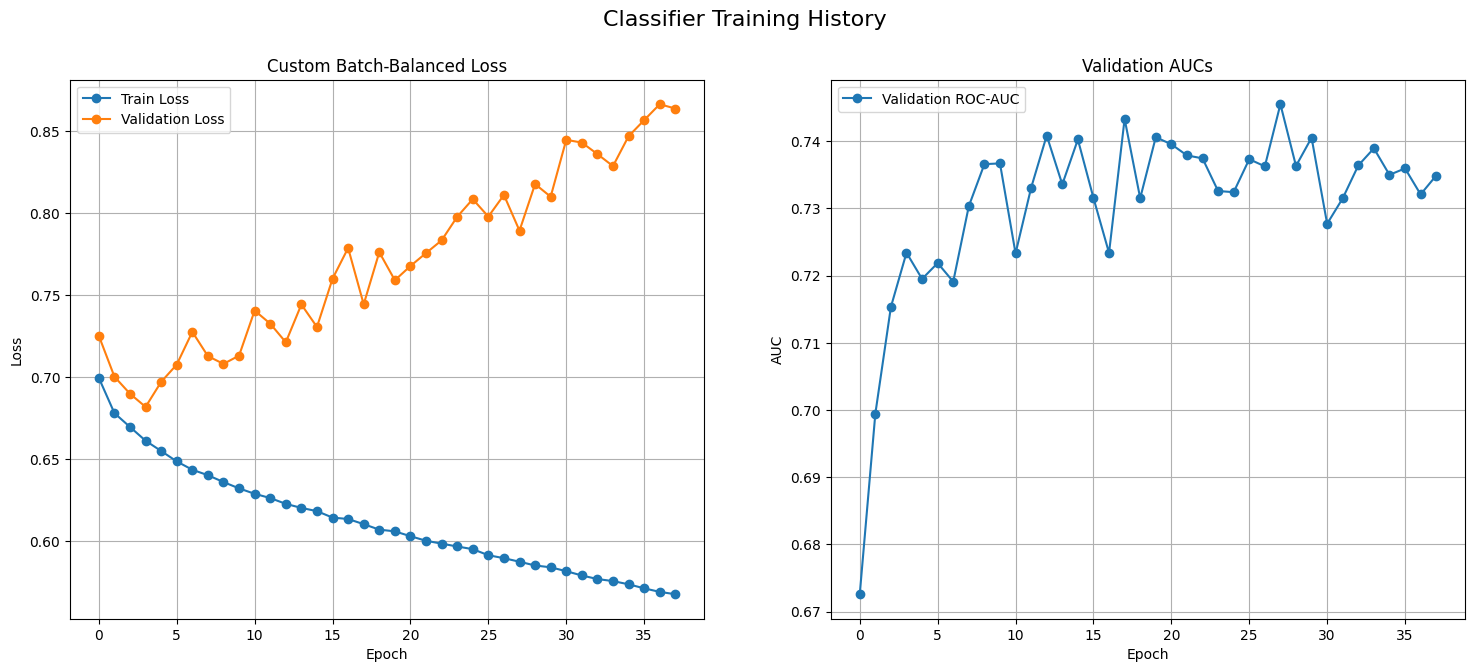

In [ ]:
# AdamW, cnfmr:2, drpt:0.5, lr = 1e-5, l1-regu = 1e-6 

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Custom Batch-Balanced Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc_roc'], 'o-', label='Validation ROC-AUC')
ax2.set_title('Validation AUCs'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()


--- Evaluating Model on the Test Set ---


I0000 00:00:1753765410.241596      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:9398229978265480670
E0000 00:00:1753765410.409436      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1_1/batch_normalization_2_1/Cast/ReadVariableOp.
I0000 00:00:1753765410.673425     905 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(14244823013092392097), session_name()
I0000 00:00:1753765416.042437     905 tpu_compile_op_common.cc:245] Compilation of 14244823013092392097 with session name  took 5.368944951s and succeeded
I0000 00:00:1753765416.057251     905 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(14244823013092392097), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_9398229978265480670", property.function_library_fingerprint = 7599768778537267769, property.mlir_mo

15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 169ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.60      0.51      0.55      1335
       Block       0.59      0.66      0.62      1982
    SoundRep       0.47      0.62      0.54       886
     WordRep       0.47      0.53      0.50       917
Interjection       0.83      0.72      0.77      1833

   micro avg       0.61      0.63      0.62      6953
   macro avg       0.59      0.61      0.60      6953
weighted avg       0.62      0.63      0.62      6953
 samples avg       0.61      0.64      0.58      6953


--- Generating plots for model training history... ---


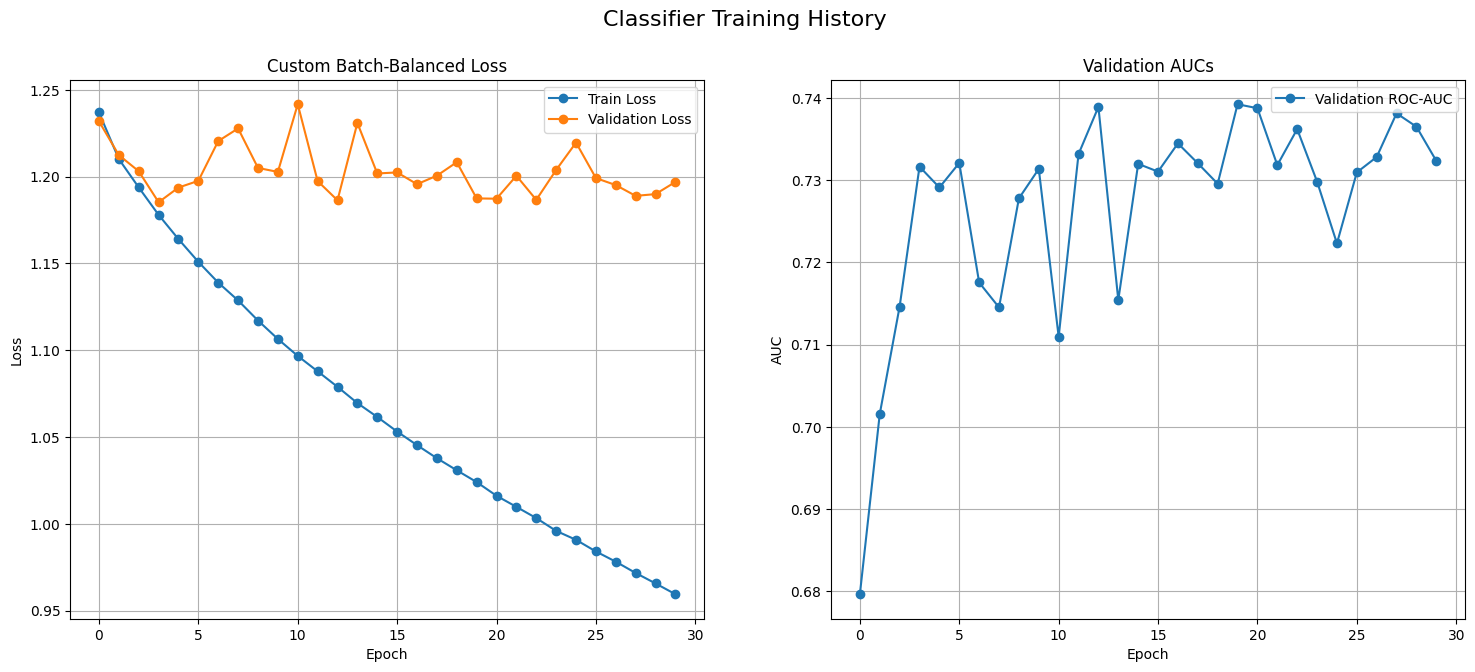

In [ ]:
# AdamW, cnfmr:2, drpt:0.5, lr = 1e-5, l1-regu = 1e-5 

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Custom Batch-Balanced Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc_roc'], 'o-', label='Validation ROC-AUC')
ax2.set_title('Validation AUCs'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()


--- Evaluating Model on the Test Set ---


I0000 00:00:1753767688.225494      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:11651450153639708462
E0000 00:00:1753767688.510841      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_2_1/batch_normalization_4_1/Cast/ReadVariableOp.
I0000 00:00:1753767688.955946     917 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(3138084179877260149), session_name()
I0000 00:00:1753767694.908616     917 tpu_compile_op_common.cc:245] Compilation of 3138084179877260149 with session name  took 5.9526089s and succeeded
I0000 00:00:1753767694.924533     917 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(3138084179877260149), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_11651450153639708462", property.function_library_fingerprint = 11192225477488359504, property.mlir_modu

15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.59      0.57      0.58      1335
       Block       0.61      0.56      0.58      1982
    SoundRep       0.54      0.48      0.51       886
     WordRep       0.51      0.47      0.49       917
Interjection       0.80      0.74      0.77      1833

   micro avg       0.64      0.59      0.61      6953
   macro avg       0.61      0.56      0.59      6953
weighted avg       0.63      0.59      0.61      6953
 samples avg       0.63      0.61      0.58      6953


--- Generating plots for model training history... ---


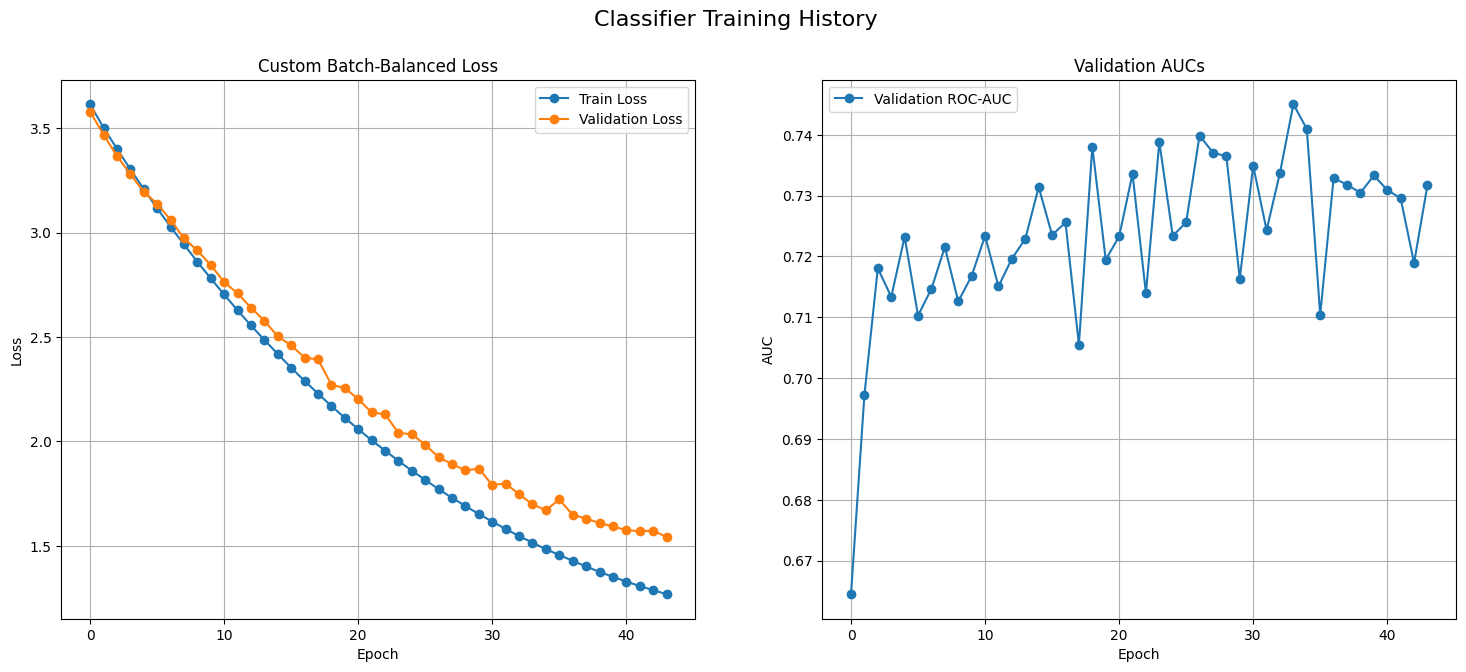

In [ ]:
# AdamW, cnfmr:2, drpt:0.4, lr = 1e-5, l1-regu = 5e-5

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Custom Batch-Balanced Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc_roc'], 'o-', label='Validation ROC-AUC')
ax2.set_title('Validation AUCs'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()


--- Evaluating Model on the Test Set ---


I0000 00:00:1753769260.614066      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:13200321697195741183
E0000 00:00:1753769260.832915      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_3_1/batch_normalization_6_1/Cast/ReadVariableOp.
I0000 00:00:1753769261.176657     890 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(8859279917689774963), session_name()
I0000 00:00:1753769268.122010     890 tpu_compile_op_common.cc:245] Compilation of 8859279917689774963 with session name  took 6.945255722s and succeeded
I0000 00:00:1753769268.137417     890 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(8859279917689774963), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_13200321697195741183", property.function_library_fingerprint = 14545466332040775367, property.mlir_mo

15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 180ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.55      0.61      0.58      1335
       Block       0.63      0.50      0.56      1982
    SoundRep       0.51      0.56      0.54       886
     WordRep       0.43      0.58      0.50       917
Interjection       0.83      0.71      0.76      1833

   micro avg       0.61      0.59      0.60      6953
   macro avg       0.59      0.59      0.59      6953
weighted avg       0.63      0.59      0.61      6953
 samples avg       0.60      0.62      0.57      6953


--- Generating plots for model training history... ---


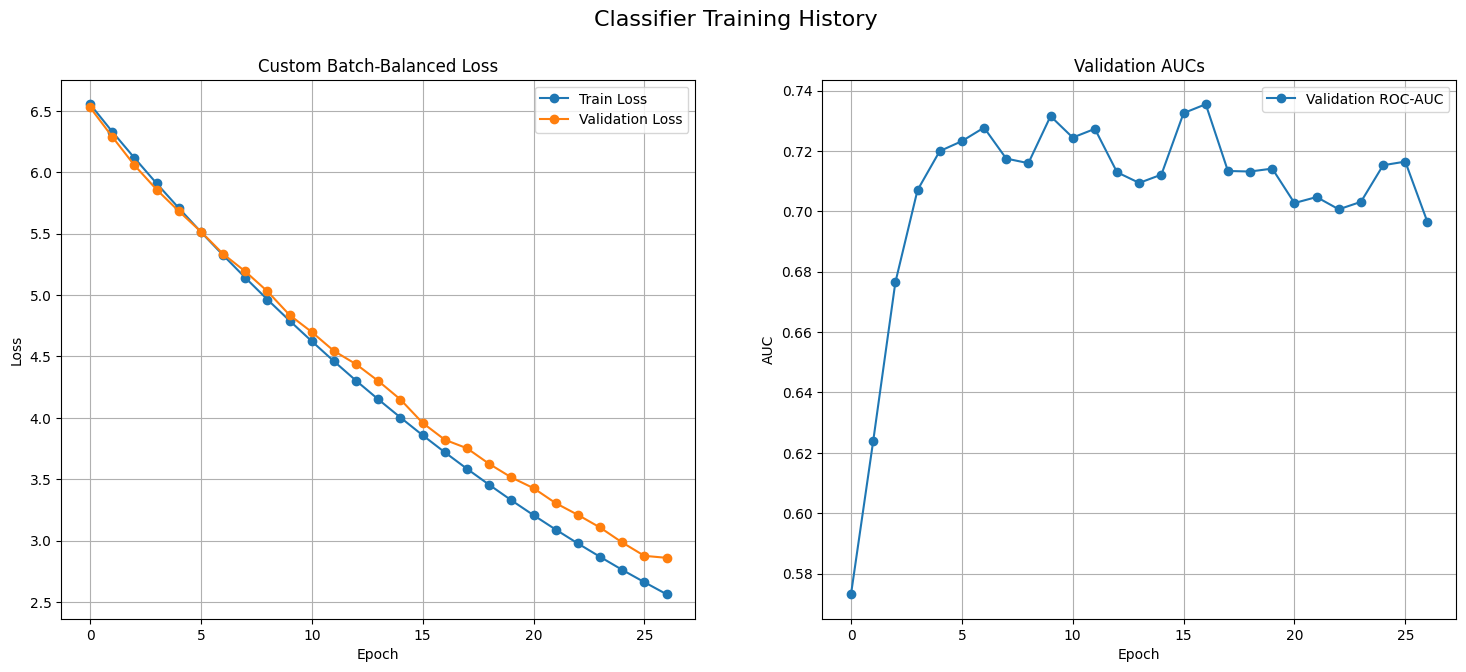

In [ ]:
# AdamW, cnfmr:4, drpt:0.4, lr = 1e-5, l1-regu = 5e-5

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Custom Batch-Balanced Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc_roc'], 'o-', label='Validation ROC-AUC')
ax2.set_title('Validation AUCs'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()


--- Evaluating Model on the Test Set ---


I0000 00:00:1753770464.413510      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:15101285266035102988
E0000 00:00:1753770464.632293      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_4_1/batch_normalization_10_1/Cast/ReadVariableOp.
I0000 00:00:1753770464.934696     942 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(6297557175477100820), session_name()
I0000 00:00:1753770471.176493     942 tpu_compile_op_common.cc:245] Compilation of 6297557175477100820 with session name  took 6.241726935s and succeeded
I0000 00:00:1753770471.191501     942 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(6297557175477100820), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_15101285266035102988", property.function_library_fingerprint = 15442623966177750130, property.mlir_m

15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.68      0.41      0.51      1335
       Block       0.57      0.55      0.56      1982
    SoundRep       0.53      0.52      0.52       886
     WordRep       0.52      0.36      0.43       917
Interjection       0.85      0.68      0.75      1833

   micro avg       0.64      0.53      0.58      6953
   macro avg       0.63      0.50      0.55      6953
weighted avg       0.65      0.53      0.58      6953
 samples avg       0.57      0.54      0.52      6953


--- Generating plots for model training history... ---


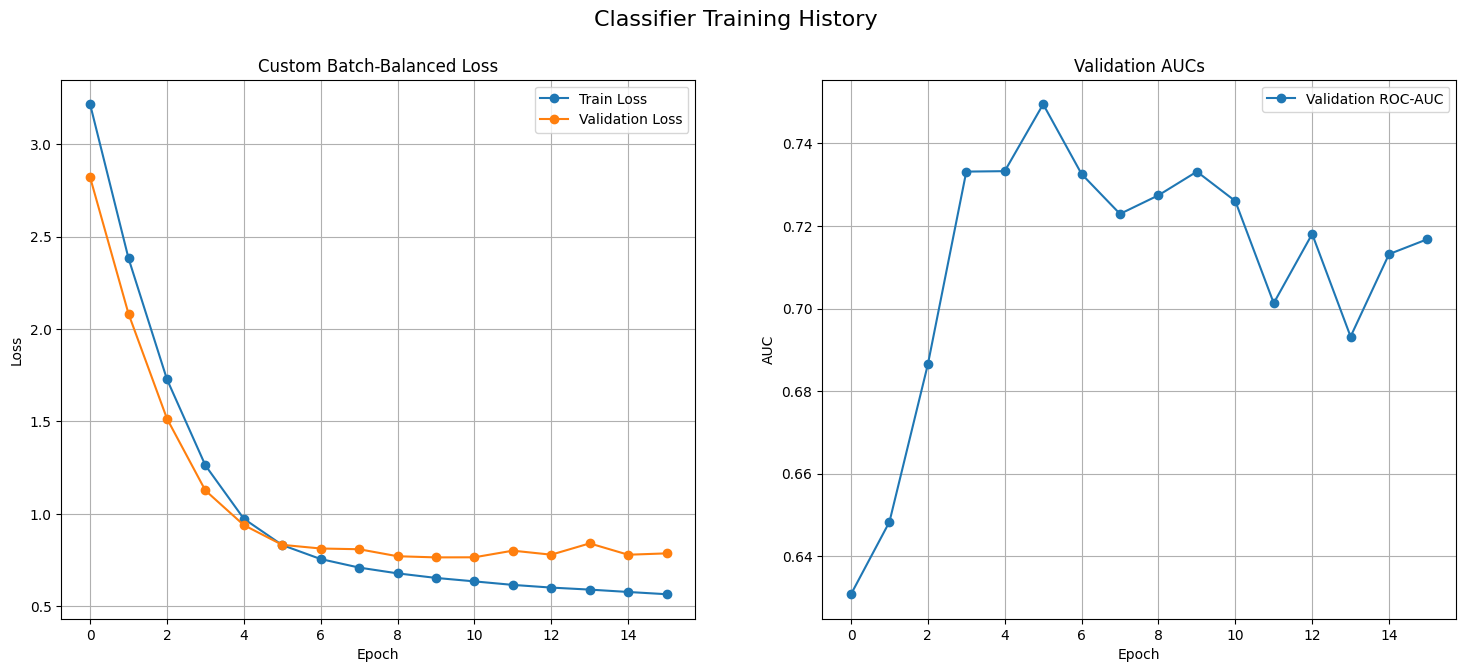

In [ ]:
# AdamW, cnfmr:2, drpt:0.4, lr = 1e-4, l1-regu = 5e-5

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Custom Batch-Balanced Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc_roc'], 'o-', label='Validation ROC-AUC')
ax2.set_title('Validation AUCs'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()